In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Reading the Files: Changed

In [52]:
# Imports from Transfer Learning video

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import random
import cv2

from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [31]:
data_dir = pathlib.Path('/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Grayscale_Augmented Dataset')
print(data_dir)

/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Grayscale_Augmented Dataset


#Read in Real Signatures from Dataset

/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Grayscale_Augmented Dataset/real/Real_original_real_321.png_10244052-f955-4e45-9908-f4020db312b4.png


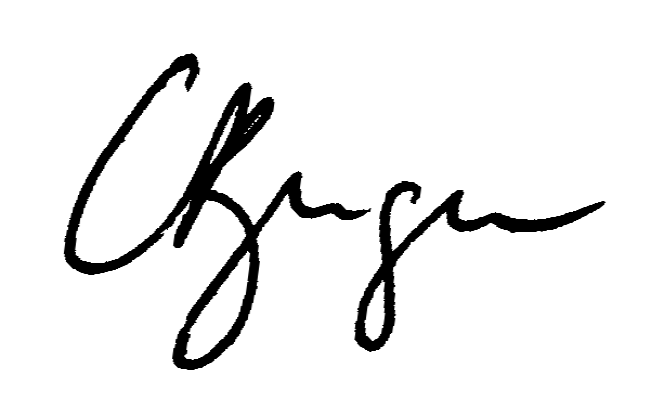

In [32]:
real = list(data_dir.glob('real/*')) 
print(real[0]) 

PIL.Image.open(str(real[0]))

/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Grayscale_Augmented Dataset/forge/Forged_original_forged_324.png_60c54766-2cac-4d80-9f3c-d3e8e243bb56.png


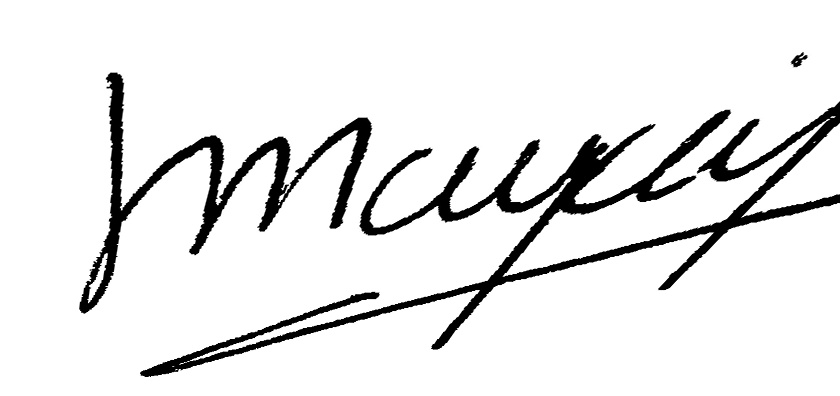

In [33]:
forge = list(data_dir.glob('forge/*'))
print(forge[0])

PIL.Image.open(str(forge[0]))

#Convert All Images to Gray Scale

In [34]:
gen = (glob.glob('/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Grayscale_Augmented Dataset/real/*.*'))

for i in range(len(gen)):
    img = Image.open(gen[i])
    imgGray = img.convert('L')
    imgGray.save(gen[i])

forg = (glob.glob('/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Grayscale_Augmented Dataset/forge/*.*'))

for i in range(len(forg)):
    img = Image.open(forg[i])
    imgGray = img.convert('L')
    imgGray.save(forg[i])

##Please Enter Name:

## Folder Name - Current Person 

Please Enter Name - "folderName" can be: 
Options: are "Evaun_Signatures", "Jon_G_Signatures", "Toni_Signature", "Andrei_Signatures".

In [57]:
folderName = "Evaun_Signatures"

/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/real/real_1.jpg


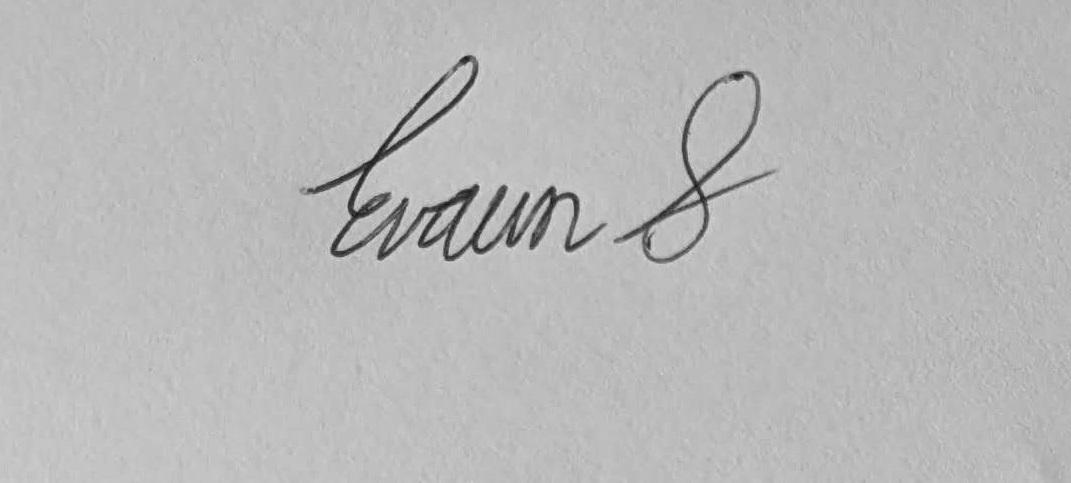

In [36]:
group_dir = pathlib.Path('/content/drive/MyDrive/Dataset_Signature_Final/Dataset/' + str(folderName))

group_mem_real = list(group_dir.glob('real/*'))
print(group_mem_real[0])

PIL.Image.open(str(group_mem_real[0]))

/content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/forge/forge_2.jpg


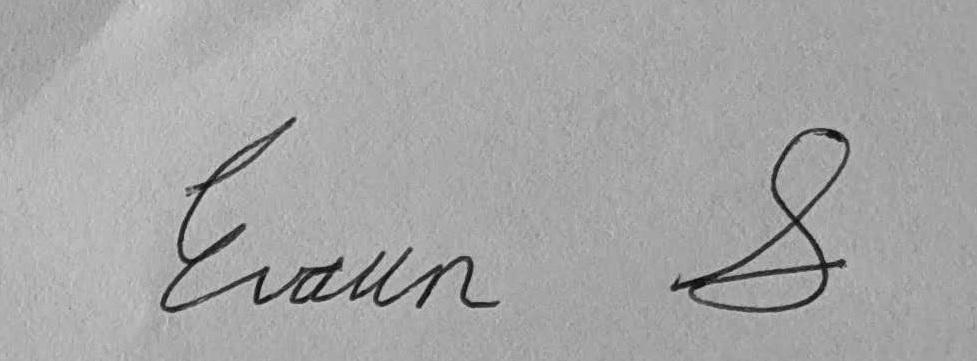

In [37]:
group_dir = pathlib.Path('/content/drive/MyDrive/Dataset_Signature_Final/Dataset/' + str(folderName))

group_mem_forge = list(group_dir.glob('forge/*'))
print(group_mem_forge[0])

PIL.Image.open(str(group_mem_forge[0]))

###Image Dimensions and Batch Size

In [38]:
img_height = 180
img_width = 180
batch_size= 32

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset="training", 
    seed=123, 
    label_mode="categorical", 
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 7234 files belonging to 2 classes.
Using 5788 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset="validation", 
    seed=123, 
    label_mode="categorical", 
    image_size=(img_height, img_width), 
    batch_size=batch_size
)


Found 7234 files belonging to 2 classes.
Using 1446 files for validation.


##Classes In Dataset

In [41]:
class_names = train_ds.class_names
print(class_names)

['forge', 'real']


#Resnet Model

In [42]:
resnet_model = Sequential() # this initializes an empty NN and ensures the layers to come are added sequentially 

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=((img_width, img_height, 3)), #may need to be changed
    pooling="avg",
    classes=2,
)

# Do not allow already trained layers to be re-trained 
# (let's them keep the weight they have)

for layer in pretrained_model.layers:
  layer.trainable = False

  
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())  # flattens the given model to 1 dimension
resnet_model.add(Dense(512, activation="relu")) #512
resnet_model.add(Dense(2, activation="softmax"))


In [43]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


In [45]:
epochs = 3

history = resnet_model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs
)


Epoch 1/3
181/181 [==============================] - 730s 4s/step - loss: 0.6214 - accuracy: 0.7070 - val_loss: 0.4619 - val_accuracy: 0.7911
Epoch 2/3
181/181 [==============================] - 721s 4s/step - loss: 0.3797 - accuracy: 0.8303 - val_loss: 0.3313 - val_accuracy: 0.8693
Epoch 3/3
181/181 [==============================] - 719s 4s/step - loss: 0.2933 - accuracy: 0.8770 - val_loss: 0.2890 - val_accuracy: 0.8741


# Evaluating the Model

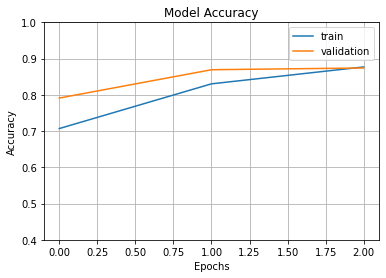

In [46]:
fig1 = plt.gcf()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.axis(ymin=0.4, ymax=1)

plt.grid()
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

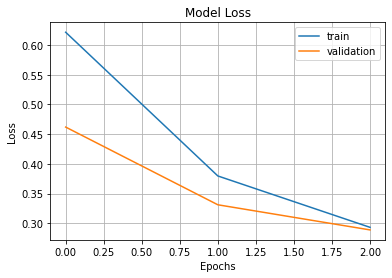

In [47]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.grid()
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

# Making Predictions

##### Shuffle Real and Forged sub-datsets

In [48]:
# from sklearn.utils import shuffle

# real, forge = shuffle(real, forge)

- Shuffle real and forged sub-datasets so that the same signatures are not used during testing

##### Place Real and Forged Signatures in one list for testing

In [49]:
both_forged_and_real = []
i = 0

for item in group_mem_real:
  if i == 5:
     break
  else:
    both_forged_and_real.append(item)
  i = i + 1

i = 0
for item in group_mem_forge:
  if i == 5:
     break
  else:
    both_forged_and_real.append(item)
  i = i + 1

random.shuffle(both_forged_and_real)
len(both_forged_and_real)

10

- The ' both_forged_and_real ' list is also shuffed.

In [53]:
# curr_set = both_forged_and_real
curr_set = both_forged_and_real

for i in range(0, 10):
  image = cv2.imread(str(curr_set[i]))
  image_resized = cv2.resize(image, (img_height, img_width))
  image = np.expand_dims(image_resized, axis=0)
  prediction = resnet_model.predict(image)
  output_class = class_names[np.argmax(prediction)]
  print("The predicted class of file with name " + str(curr_set[i]), "is", output_class)

print("\nDone")

The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/real/real_1.jpg is real
The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/forge/forge_2.jpg is forge
The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/real/real_3.jpg is forge
The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/real/real_2.jpg is real
The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/forge/forge_4.jpg is forge
The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/forge/forge_1.jpg is forge
The predicted class of file with name /content/drive/MyDrive/Dataset_Signature_Final/Dataset/Evaun_Signatures/forge/forge_3.jpg is real
The predicted class of file with name /content/dri